# Cirrhosis Prediction

by Hikmat Ashqar 
27/4/2024 

## Context 


Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

## Attribute Information


1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

## Helper func 

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


def roc_fun(model_pipe, X_train, y_train, X_test, y_test):

 # roc_auc
  y_pred_proba_train = model_pipe.predict_proba(X_train)
  y_pred_proba_test = model_pipe.predict_proba(X_test)
  train_roc_auc = roc_auc_score(y_train, y_pred_proba_train[:,1])
  test_roc_auc = roc_auc_score(y_test, y_pred_proba_test[:,1])

  print(f'Training ROC AUC: {train_roc_auc:.2f}')
  print(f'Test ROC AUC: {test_roc_auc:.2f}')
  print()
  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  # Visualize the ROC curve
  RocCurveDisplay.from_estimator(model_pipe, X_train, y_train, ax=axes[0])
  axes[0].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[0].legend();
  axes[0].set_title("Training Data")

  RocCurveDisplay.from_estimator(model_pipe, X_test, y_test, ax=axes[1])
  axes[1].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[1].legend();
  axes[1].set_title("Test Data")

  fig.suptitle('ROC Curves')
  fig.tight_layout()
  plt.show()


def evaluate_classification_combined(model, X_train, y_train, X_test, y_test,
                         figsize=(8,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )


  roc_fun(model, X_train, y_train, X_test, y_test)


  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)



In [95]:

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax




def explore_numeric(df, x, figsize=(6,5) ):
# Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100

  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")


# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
    # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



def plot_multi_numeric_vs_target(df, xs, y, figsize=(6,4), target_type='reg',
                           estimator='mean', errorbar='ci', sorted=False,
                           ascending=False, **kwargs):
    nulls = df[xs + [y]].isna().sum()
    if nulls.sum() > 0:
        print(f"- Excluding {nulls.sum()} NaN's")
        temp_df = df.dropna(subset=xs + [y])
    else:
        temp_df = df

    # Calculate grid size for subplots
    n = len(xs)
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))

    # Create the figure with subplots
    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0]*cols, figsize[1]*rows))
    axs = axs.flatten() # Flatten in case of a single row/column to simplify indexing

    for i, x in enumerate(xs):
        ax = axs[i]
        if 'reg' in target_type:
            # Calculate the correlation
            corr = temp_df[[x, y]].corr().round(2)
            r = corr.loc[x, y]
            # Plot the data
            scatter_kws = {'ec': 'white', 'lw': 1, 'alpha': 0.8}
            sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
            ax.set_title(f"{x} vs. {y} (r = {r})")
        elif 'class' in target_type:
            # Sorting and ordering logic remains the same
            if sorted:
                if estimator == 'median':
                    group_vals = temp_df.groupby(y)[x].median()
                elif estimator == 'mean':
                    group_vals = temp_df.groupby(y)[x].mean()
                group_vals = group_vals.sort_values(ascending=ascending)
                order = group_vals.index
            else:
                order = None
            sns.barplot(data=temp_df, x=y, y=x, order=order, estimator=estimator,
                        errorbar=errorbar, ax=ax, **kwargs)
            ax.set_title(f"{x} vs. {y}")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        if i >= n: # If we have more subplots than features, hide the extra axes
            ax.set_visible(False)

    # Final Adjustments & return
    plt.tight_layout()
    plt.show()
    return fig, axs

## Data Loading 

In [121]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

import warnings
warnings.filterwarnings("ignore")



In [97]:
# Load Data
df = pd.read_csv("C:/Users/hekmat.ashqar/Documents/GitHub/Prediction-of-liver-cirrhosis/cirrhosis.csv")
df.head()

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

## Data Inspecting 

In [99]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

 Drop all the rows where miss value (NA) were present in the Drug column

In [100]:
df = df.dropna(subset=['Drug'])


In [101]:
df.isna().sum()

ID                0
N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

we will impute other missing value later 

In [102]:
df.duplicated().sum()

0

### checking data types 

#### inspecting numerical column

In [103]:
df.dtypes

ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [104]:
df.describe()

ID       N_Days           Age   Bilirubin  Cholesterol  \
count  312.000000   312.000000    312.000000  312.000000   284.000000   
mean   156.500000  2006.362179  18269.442308    3.256090   369.510563   
std     90.210864  1123.280843   3864.805407    4.530315   231.944545   
min      1.000000    41.000000   9598.000000    0.300000   120.000000   
25%     78.750000  1191.000000  15427.750000    0.800000   249.500000   
50%    156.500000  1839.500000  18187.500000    1.350000   309.500000   
75%    234.250000  2697.250000  20715.000000    3.425000   400.000000   
max    312.000000  4556.000000  28650.000000   28.000000  1775.000000   

          Albumin      Copper      Alk_Phos        SGOT  Tryglicerides  \
count  312.000000  310.000000    312.000000  312.000000     282.000000   
mean     3.520000   97.648387   1982.655769  122.556346     124.702128   
std      0.419892   85.613920   2140.388824   56.699525      65.148639   
min      1.960000    4.000000    289.000000   26.350000      33.000000   
25%      3.310000   41.250000    871.500000   80.600000      84.250000   
50%      3.550000   73.000000   1259.000000  114.700000     108.000000   
75%      3.800000  123.000000   1980.000000  151.900000     151.000000   
max      4.640000  588.000000  13862.400000  457.250000     598.000000   

        Platelets  Prothrombin       Stage  
count  308.000000   312.000000  312.000000  
mean   261.935065    10.725641    3.032051  
std     95.608742     1.004323    0.877880  
min     62.000000     9.000000    1.000000  
25%    199.750000    10.000000    2.000000  
50%    257.000000    10.600000    3.000000  
75%    322.500000    11.100000    4.000000  
max    563.000000    17.100000    4.000000

Age has a max value of 28650 but since it is in days 28650/365=78.4931507 it is making scence  and we checked other column and have normal values considering this is medical data set for patient 


In [105]:
data_types = df.dtypes
str_cols = data_types[data_types=='object'].index
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- Status:
C     168
D     125
CL     19
Name: Status, dtype: int64



- Drug:
D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64



- Sex:
F    276
M     36
Name: Sex, dtype: int64



- Ascites:
N    288
Y     24
Name: Ascites, dtype: int64



- Hepatomegaly:
Y    160
N    152
Name: Hepatomegaly, dtype: int64



- Spiders:
N    222
Y     90
Name: Spiders, dtype: int64



- Edema:
N    263
S     29
Y     20
Name: Edema, dtype: int64





## Exploratory Data Analysis

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 311
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             312 non-null    int64  
 1   N_Days         312 non-null    int64  
 2   Status         312 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            312 non-null    int64  
 5   Sex            312 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          312 non-null    object 
 10  Bilirubin      312 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        312 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      308 non-null    float64
 18  Prothrombi

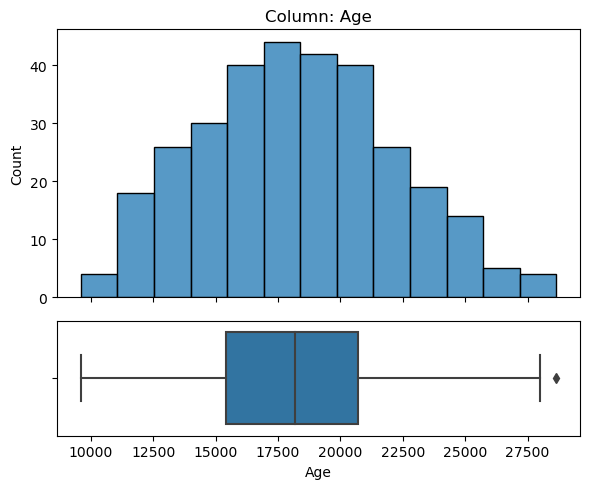

- NaN's Found: 0 (0.0%)
- Unique Values: 308
- Most common value: '22960' occurs 2 times (0.64%)


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


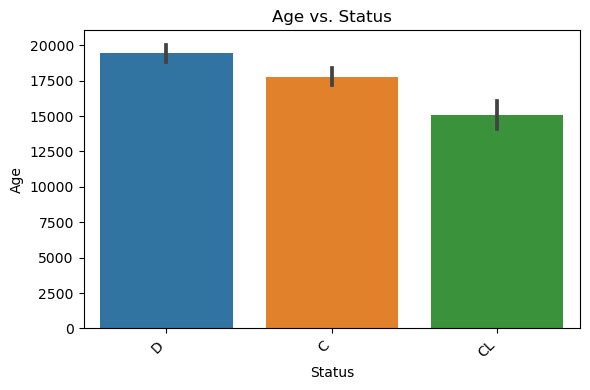

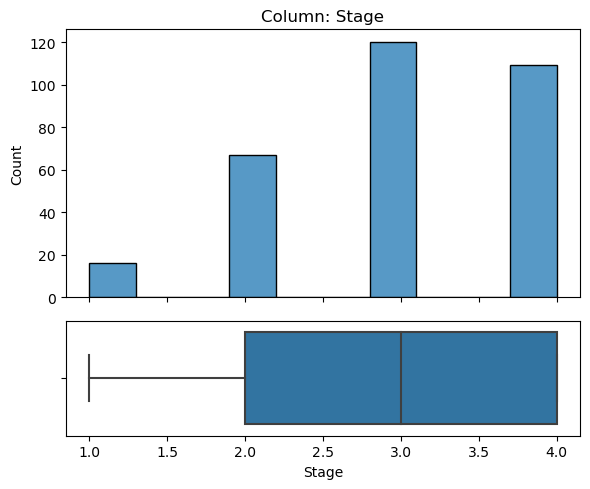

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '3.0' occurs 120 times (38.46%)


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


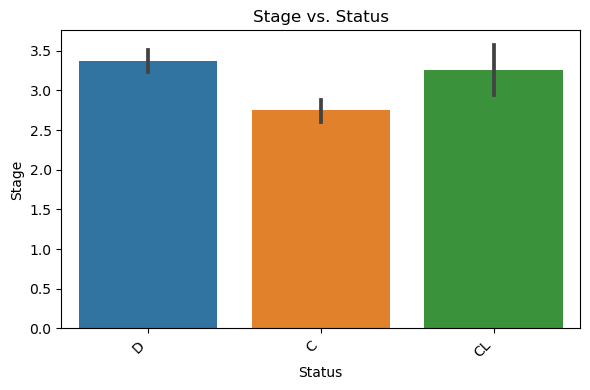

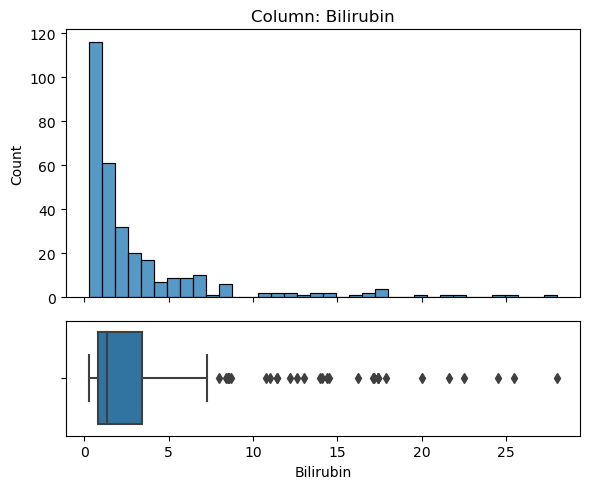

- NaN's Found: 0 (0.0%)
- Unique Values: 85
- Most common value: '0.6' occurs 22 times (7.05%)


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


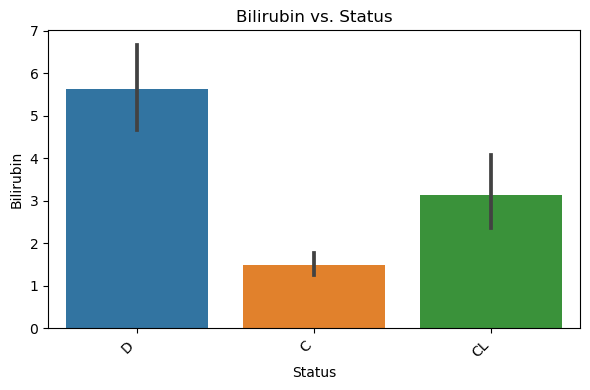

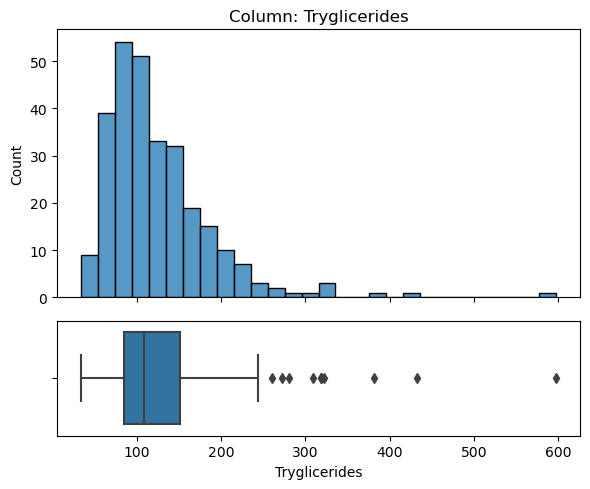

- NaN's Found: 30 (9.62%)
- Unique Values: 146
- Most common value: 'nan' occurs 30 times (9.62%)
- Excluding 30 NaN's


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


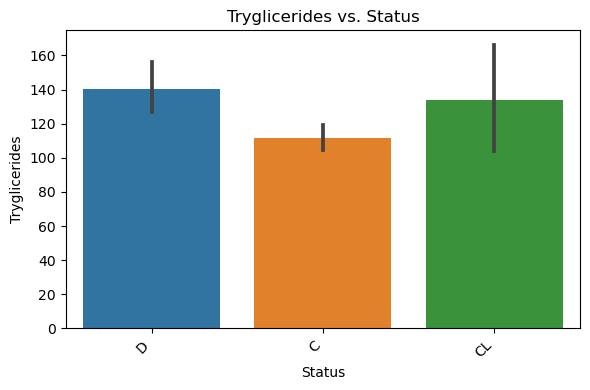

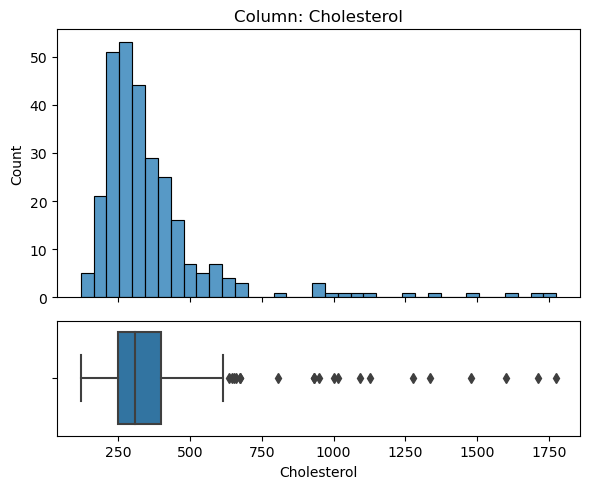

- NaN's Found: 28 (8.97%)
- Unique Values: 201
- Most common value: 'nan' occurs 28 times (8.97%)
- Excluding 28 NaN's


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


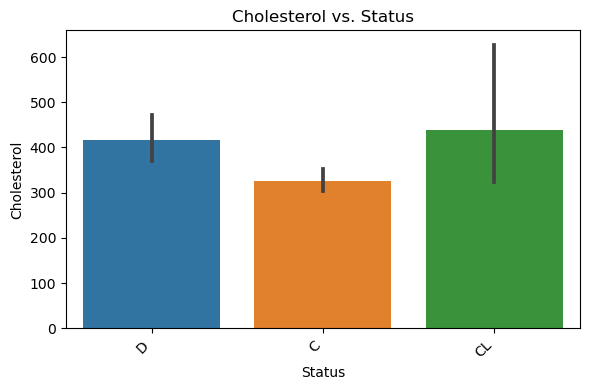

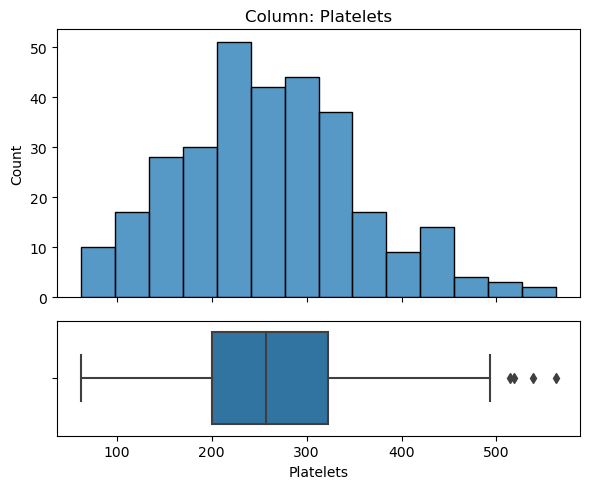

- NaN's Found: 4 (1.28%)
- Unique Values: 210
- Most common value: '344.0' occurs 6 times (1.92%)
- Excluding 4 NaN's


C:\Users\hekmat.ashqar\AppData\Local\Temp\ipykernel_27392\702433938.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


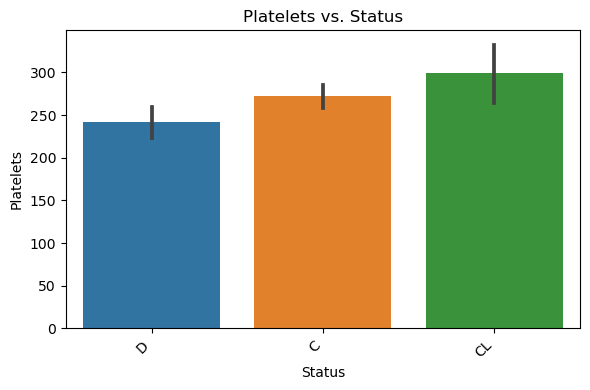

In [107]:
numerical_columns = ['Age','Stage','Bilirubin','Tryglicerides' ,'Cholesterol','Platelets']

# Loop through numerical columns and plot histograms
for col in numerical_columns:
  explore_numeric(df,x=col)
  plot_numeric_vs_target(df, x=col, y='Status', figsize=(6,4),target_type='class');

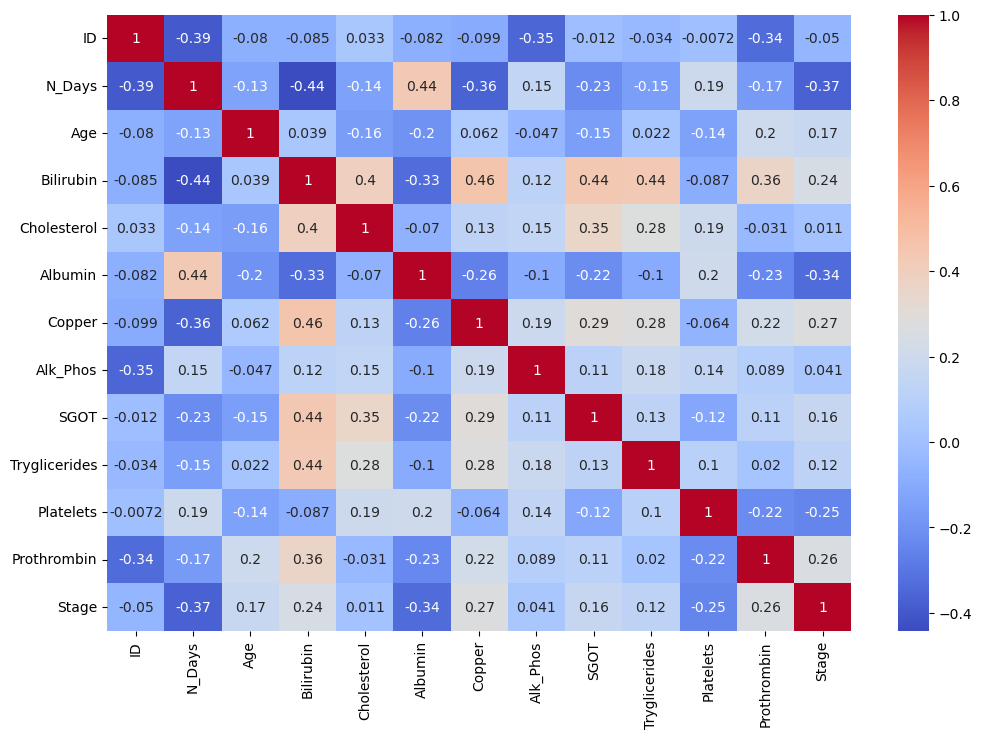

In [108]:
# Get correlations
corr = df.corr(numeric_only = True)
corr.round(2)
# Create a fig, ax with a figsize argument
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, ax=ax);

- **Data Analysis Summary**

- **Numeric Features Analysis**

- **Age**:
  - Age shows slight variations across patient statuses (C, CL, D), indicating a moderate influence of age on outcomes.
  
- **Bilirubin**:
  - Elevated bilirubin levels are observed in patients with more severe outcomes (status D), highlighting its potential as a critical predictive marker.
  
- **Triglycerides**:
  - Higher triglyceride levels correlate with more severe disease outcomes, suggesting a link between metabolic profiles and disease severity.
  
- **Cholesterol**:
  - Cholesterol levels are highest in patients who underwent liver transplantation, warranting further investigation into its role in patient management and outcomes.



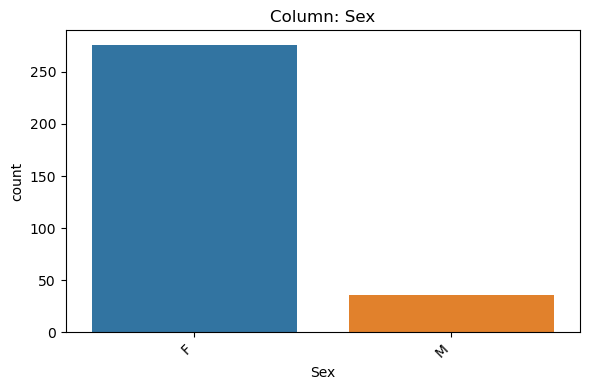

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'F' occurs 276 times (88.46%)
- Not constant or quasi-constant.


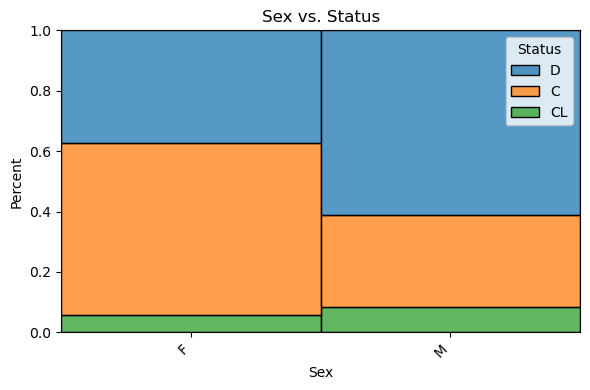

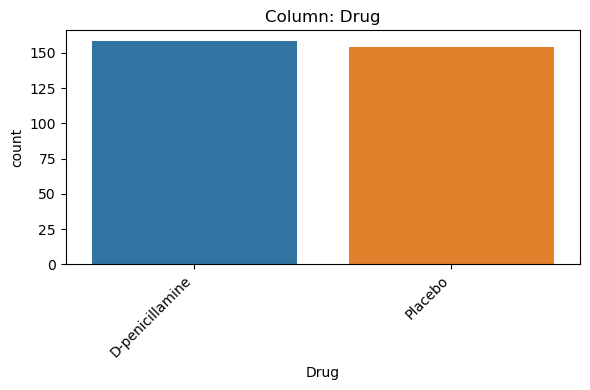

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'D-penicillamine' occurs 158 times (50.64%)
- Not constant or quasi-constant.


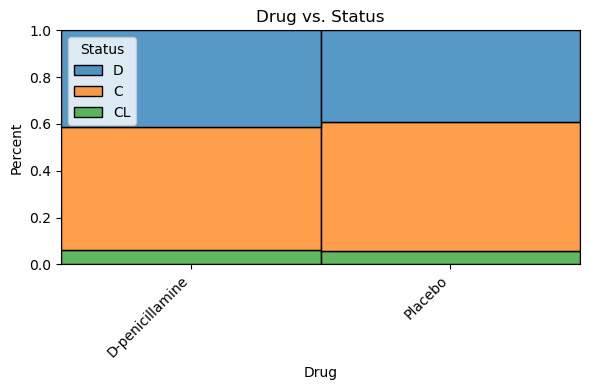

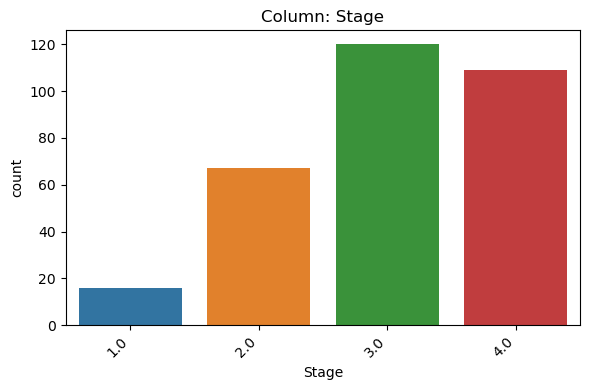

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '3.0' occurs 120 times (38.46%)
- Not constant or quasi-constant.


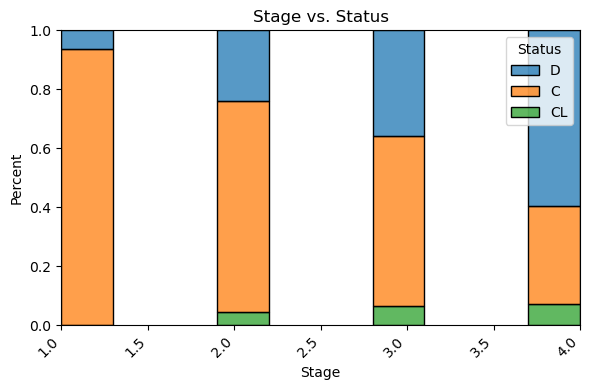

In [109]:
explore_categorical(df,x='Sex', fillna = True, placeholder = 'MISSING');
plot_categorical_vs_target(df, x='Sex', y='Status', figsize=(6,4),target_type='class');

explore_categorical(df,x='Drug', fillna = True, placeholder = 'MISSING');
plot_categorical_vs_target(df, x='Drug', y='Status', figsize=(6,4),target_type='class');

 
explore_categorical(df,x='Stage', fillna = True, placeholder = 'MISSING');
plot_categorical_vs_target(df, x='Stage', y='Status', figsize=(6,4),target_type='class');

 

**Categorical Features Analysis**

- **Sex**:
  - The majority of patients are female, with similar outcomes across genders, reflecting the known higher prevalence of PBC in women.
  
- **Drug**:
  - No significant difference in patient outcomes between the D-penicillamine and placebo groups, suggesting a minimal impact of these treatments on the progression of PBC in this dataset.

 
- **Stage of Disease**:
  - Advanced disease stages are strongly associated with severe outcomes (death or transplantation), affirming the progressive nature of PBC.
 
-  **Stage vs. Status**

- **Stage 1**: Higher proportion of censored patients (C), suggesting better prognosis or less severe disease manifestation at this early stage.
- **Stage 2-4**: Increasing counts of deaths (D) and liver transplants (CL) as the stage progresses, illustrating a clear trend where advanced stages are associated with more severe outcomes.

-  **Insights and Recommendations**

- The stage of the disease is clearly linked to patient outcomes, with advanced stages showing increased severity, reinforcing the need for early diagnosis and intervention.
- These insights can be crucial for clinical strategies focusing on early detection and management to potentially halt disease progression.

## Modeling 

### Preprocessing 

In [110]:
# Make a list of features to drop
# Define features matrix
X = df.drop(columns = ['Status','ID'])
# Define target
y = df['Status']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Preview training data
X_train.head()

N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
119    2033  D-penicillamine  12839   M       N            N       N     N   
258    1615          Placebo  21904   F       N            Y       N     N   
244    1790          Placebo  16718   F       N            Y       N     N   
204    2081  D-penicillamine  17889   F       Y            N       N     N   
137    1297  D-penicillamine  18719   M       N            Y       N     N   

     Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos   SGOT  Tryglicerides  \
119        3.5        325.0     3.98   444.0     766.0  130.2          210.0   
258        3.1        277.0     2.97    42.0    1110.0  125.0          126.0   
244        0.6        273.0     3.65    48.0     794.0   52.7          214.0   
204        2.5        382.0     3.55   108.0    1516.0  238.7            NaN   
137        7.3        426.0     3.93   262.0    2424.0  145.7          218.0   

     Platelets  Prothrombin  Stage  
119      344.0         10.6    3.0  
258      221.0          9.8    3.0  
244      305.0          9.6    3.0  
204      126.0         10.3    3.0  
137      252.0         10.5    3.0

In [111]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( impute_median)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


Numeric Columns: Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')


Median imputation would be appropriate for cholesterol to handle the skewness and potential outliers effectively.
 and Triglycerides ,median imputation here as well, to avoid the influence of outliers.

In [112]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names

ohe_cols = X_train.select_dtypes('object').columns
ohe_cols
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')


In [113]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=False)
# Fit on training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

### old Modeling 

In [80]:
# Initialize and train a default random forest model
rf_model = RandomForestClassifier(random_state=42)
# Make a pipeline to scale the data and fit a model
rf_model_pipe = make_pipeline(preprocessor, rf_model)
# Fit the model on the training data
rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       131
          CL       1.00      1.00      1.00        10
           D       1.00      1.00      1.00        93

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



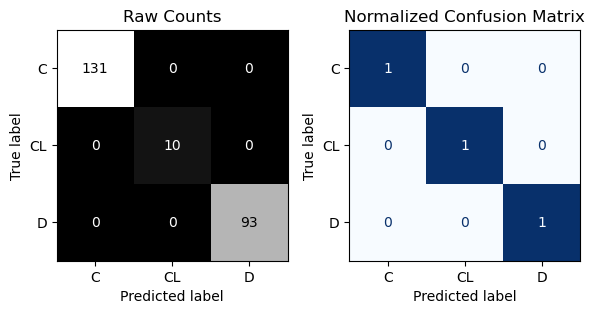


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.70      0.89      0.79        37
          CL       0.00      0.00      0.00         9
           D       0.74      0.72      0.73        32

    accuracy                           0.72        78
   macro avg       0.48      0.54      0.51        78
weighted avg       0.64      0.72      0.67        78



C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

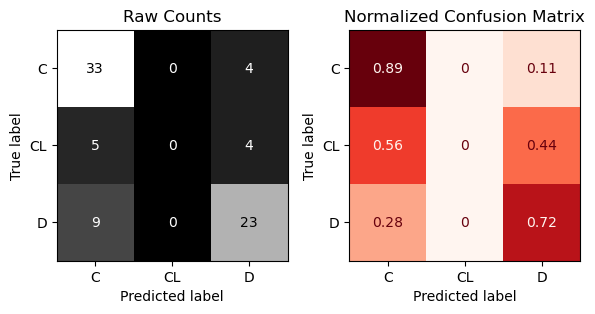

C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [81]:
results = evaluate_classification(rf_model_pipe,X_train, y_train, X_test, y_test,output_dict=True)


In [83]:
# fit column transformer and run get_feature_names_out

feature_names = preprocessor.get_feature_names_out()
X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_tf.head(3)

N_Days      Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
228   348.0  22797.0        4.5        191.0     3.05   200.0    1020.0   
9      51.0  25772.0       12.6        200.0     2.74   140.0     918.0   
57   4459.0  16279.0        0.7        242.0     4.08    73.0    5890.0   

       SGOT  Tryglicerides  Platelets  Prothrombin  Stage  \
228  175.15          118.0      139.0         11.4    4.0   
9    147.25          143.0      302.0         11.5    4.0   
57    56.76          118.0      262.0         10.6    1.0   

     Drug_D-penicillamine  Drug_Placebo  Sex_F  Sex_M  Ascites_N  Ascites_Y  \
228                   1.0           0.0    1.0    0.0        0.0        1.0   
9                     0.0           1.0    1.0    0.0        0.0        1.0   
57                    1.0           0.0    0.0    1.0        1.0        0.0   

     Hepatomegaly_N  Hepatomegaly_Y  Spiders_N  Spiders_Y  Edema_N  Edema_S  \
228             0.0             1.0        1.0        0.0      0.0      1.0   
9               1.0             0.0        0.0        1.0      0.0      0.0   
57              1.0             0.0        1.0        0.0      1.0      0.0   

     Edema_Y  
228      0.0  
9        1.0  
57       0.0

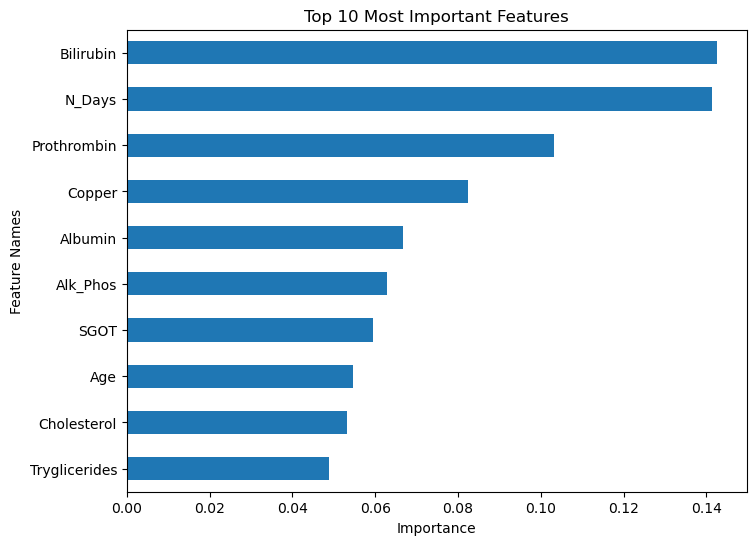

In [87]:
 
# Saving the feature importances
importances = get_importances(rf_model)
plot_importance(importances, top_n=10);

In [90]:
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_model, X_test_tf, y_test,n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [91]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances



Bilirubin               0.041026
Prothrombin             0.033333
N_Days                  0.028205
Age                     0.025641
Copper                  0.023077
SGOT                    0.017949
Hepatomegaly_Y          0.012821
Albumin                 0.010256
Alk_Phos                0.007692
Stage                   0.007692
Edema_N                 0.005128
Platelets               0.005128
Ascites_N               0.002564
Hepatomegaly_N          0.000000
Spiders_Y               0.000000
Spiders_N               0.000000
Edema_S                 0.000000
Drug_D-penicillamine    0.000000
Ascites_Y               0.000000
Sex_M                   0.000000
Sex_F                   0.000000
Drug_Placebo            0.000000
Tryglicerides           0.000000
Cholesterol             0.000000
Edema_Y                 0.000000
Name: permutation importance, dtype: float64

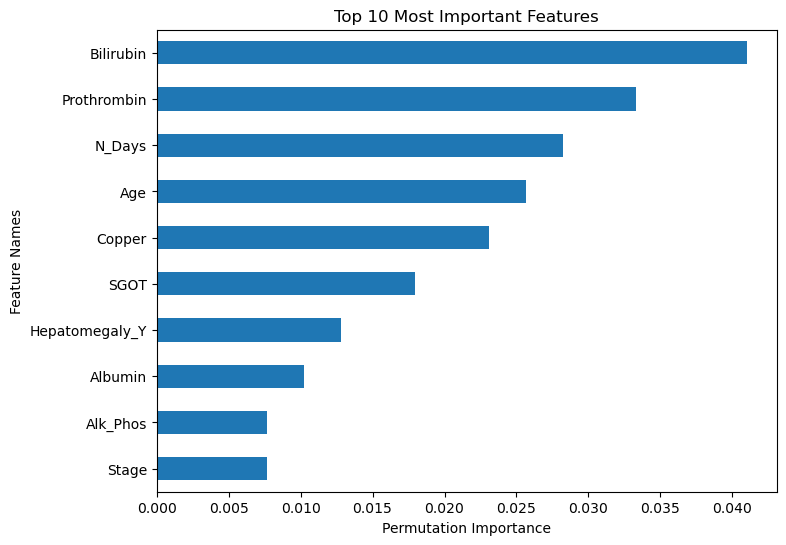

In [92]:
ax = plot_importance(permutation_importances,top_n=10)
ax.set(xlabel='Permutation Importance');


### helper func 

In [82]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict
def plot_importance_color(importances, top_n=None,  figsize=(8,6),
                          color_dict=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax


def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax


### new Modeling 

In [152]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names


array(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M',
       'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y',
       'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'],
      dtype=object)

#### Remaking Our X_train and X_test as DataFrames with the New Feature Names

In [115]:
X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_tf.head(3)
X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_tf.head(3)

N_Days      Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
228   348.0  22797.0        4.5        191.0     3.05   200.0    1020.0   
9      51.0  25772.0       12.6        200.0     2.74   140.0     918.0   
57   4459.0  16279.0        0.7        242.0     4.08    73.0    5890.0   

       SGOT  Tryglicerides  Platelets  Prothrombin  Stage  \
228  175.15          118.0      139.0         11.4    4.0   
9    147.25          143.0      302.0         11.5    4.0   
57    56.76          118.0      262.0         10.6    1.0   

     Drug_D-penicillamine  Drug_Placebo  Sex_F  Sex_M  Ascites_N  Ascites_Y  \
228                   1.0           0.0    1.0    0.0        0.0        1.0   
9                     0.0           1.0    1.0    0.0        0.0        1.0   
57                    1.0           0.0    0.0    1.0        1.0        0.0   

     Hepatomegaly_N  Hepatomegaly_Y  Spiders_N  Spiders_Y  Edema_N  Edema_S  \
228             0.0             1.0        1.0        0.0      0.0      1.0   
9               1.0             0.0        0.0        1.0      0.0      0.0   
57              1.0             0.0        1.0        0.0      1.0      0.0   

     Edema_Y  
228      0.0  
9        1.0  
57       0.0

In [116]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

228    D
9      D
57     C
Name: Status, dtype: object

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       131
          CL       1.00      1.00      1.00        10
           D       1.00      1.00      1.00        93

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



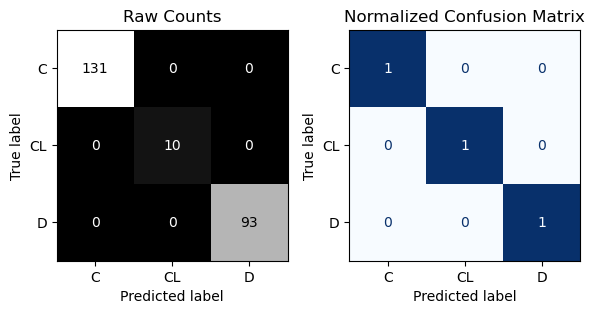


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.70      0.89      0.79        37
          CL       0.00      0.00      0.00         9
           D       0.74      0.72      0.73        32

    accuracy                           0.72        78
   macro avg       0.48      0.54      0.51        78
weighted avg       0.64      0.72      0.67        78



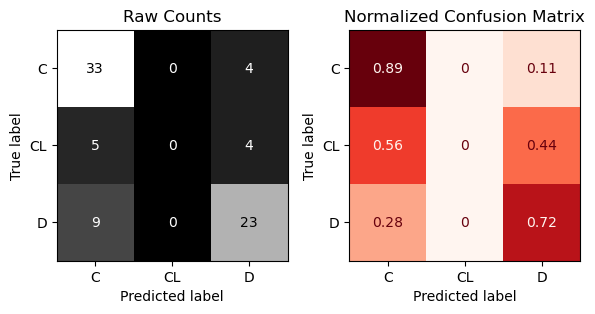

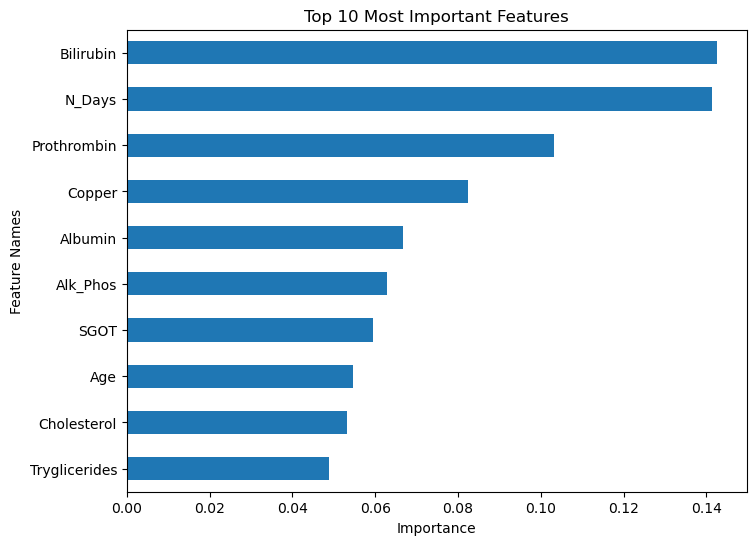

In [122]:
reg_B = RandomForestClassifier(random_state = 42)
reg_B.fit(X_train_tf, y_train)
evaluate_classification(reg_B, X_train_tf, y_train, X_test_tf,y_test)
## Saving the feature importances
importances = get_importances(reg_B, sort=True, ascending=False)
plot_importance(importances, top_n=10);



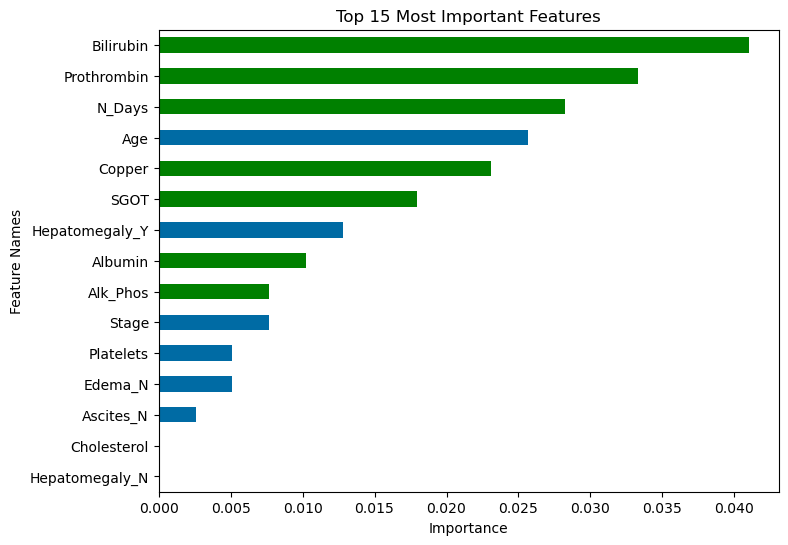

In [158]:
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(reg_B, X_test_tf, y_test,n_jobs=-1,n_repeats =5, random_state = 42)
r.keys()
colors_rf = get_color_dict(importances,top_n=7)
# make mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_tf.columns,
                           name = 'permutation importance')
# sort before plotting
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
# plot with custom function
plot_importance_color(rf_perm_importances,color_dict=colors_rf,top_n=15);



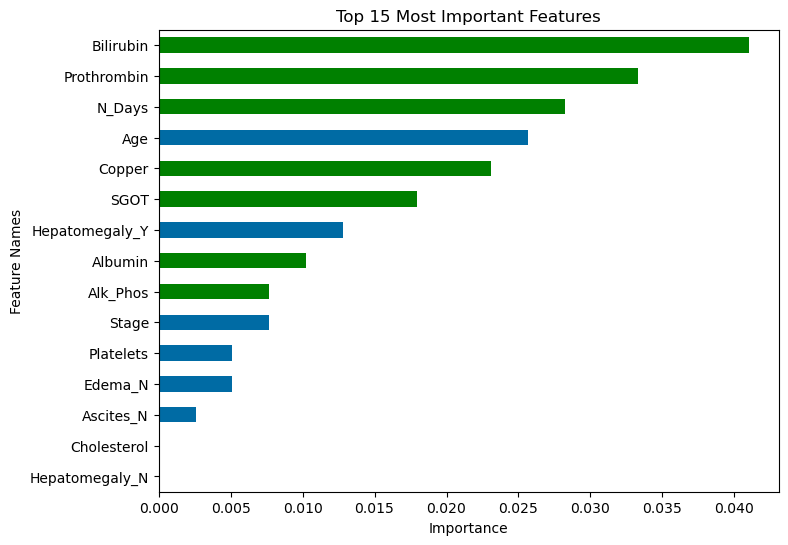

In [155]:
 colors_rf = get_color_dict(importances,top_n=7)
# make mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_tf.columns,
                           name = 'permutation importance')
# sort before plotting
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
# plot with custom function
plot_importance_color(rf_perm_importances,color_dict=colors_rf,top_n=15);



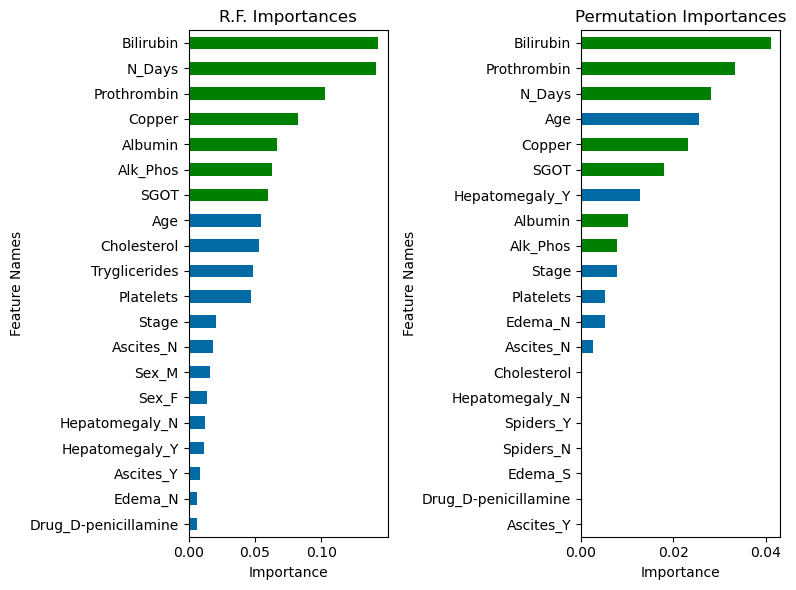

In [159]:
colors_top7 = get_color_dict(importances, top_n=7)
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 20 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

### Post-Modeling EDA


In [136]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_tf, y_train],axis=1)
plot_df_test = pd.concat([X_test_tf, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df.head()


N_Days      Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
119  2033.0  12839.0        3.5        325.0     3.98   444.0     766.0   
258  1615.0  21904.0        3.1        277.0     2.97    42.0    1110.0   
244  1790.0  16718.0        0.6        273.0     3.65    48.0     794.0   
204  2081.0  17889.0        2.5        382.0     3.55   108.0    1516.0   
137  1297.0  18719.0        7.3        426.0     3.93   262.0    2424.0   

      SGOT  Tryglicerides  Platelets  Prothrombin  Stage  \
119  130.2          210.0      344.0         10.6    3.0   
258  125.0          126.0      221.0          9.8    3.0   
244   52.7          214.0      305.0          9.6    3.0   
204  238.7          111.0      126.0         10.3    3.0   
137  145.7          218.0      252.0         10.5    3.0   

     Drug_D-penicillamine  Drug_Placebo  Sex_F  Sex_M  Ascites_N  Ascites_Y  \
119                   1.0           0.0    0.0    1.0        1.0        0.0   
258                   0.0           1.0    1.0    0.0        1.0        0.0   
244                   0.0           1.0    1.0    0.0        1.0        0.0   
204                   1.0           0.0    1.0    0.0        0.0        1.0   
137                   1.0           0.0    0.0    1.0        1.0        0.0   

     Hepatomegaly_N  Hepatomegaly_Y  Spiders_N  Spiders_Y  Edema_N  Edema_S  \
119             1.0             0.0        1.0        0.0      1.0      0.0   
258             0.0             1.0        1.0        0.0      1.0      0.0   
244             0.0             1.0        1.0        0.0      1.0      0.0   
204             1.0             0.0        1.0        0.0      1.0      0.0   
137             0.0             1.0        1.0        0.0      1.0      0.0   

     Edema_Y Status  
119      0.0     CL  
258      0.0      C  
244      0.0      C  
204      0.0      D  
137      0.0      D

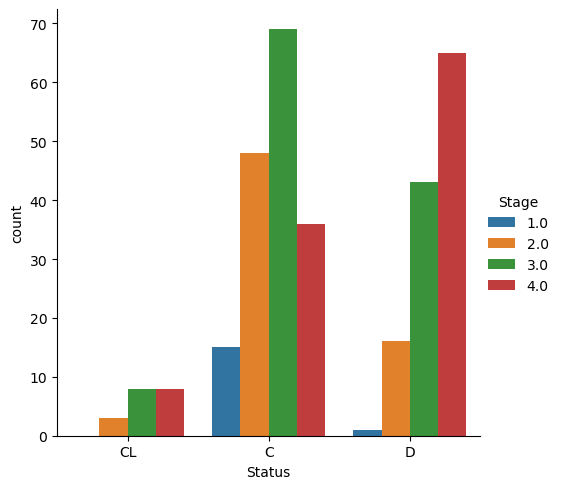

In [137]:
sns.catplot(data=plot_df, kind='count', x='Status', hue='Stage');

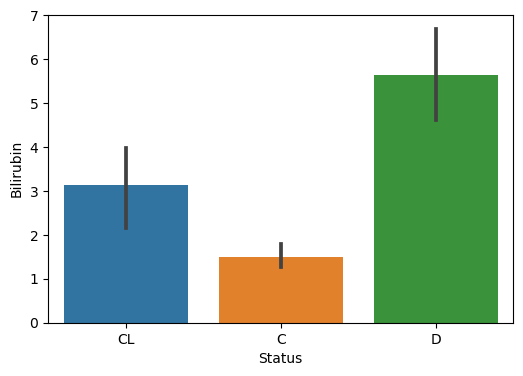

In [138]:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x='Status',y='Bilirubin')